## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_csv("data_clean/nyc_taxi_combined_2025_cleaned.csv")
df.head()

,Trip_ID,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,cbd_congestion_fee,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,taxi_type,tip_amount,tolls_amount,total_amount,trip_distance,trip_duration_min
0,1,2025-07-25 19:01:33,2025-07-25 19:08:08,141,233,0.75,2.5,2.50,7.9,1.0,0.5,1.0,1.0,yellow,3.03,0.0,18.18,0.79,6.58
1,2,2025-07-13 18:50:00,2025-07-13 18:52:26,107,137,0.75,2.5,3.25,5.1,1.0,0.5,1.0,2.0,yellow,0.00,0.0,9.85,0.60,2.43
2,3,2025-07-30 10:49:19,2025-07-30 11:09:03,186,170,0.75,2.5,0.00,17.0,1.0,0.5,1.0,1.0,yellow,4.35,0.0,26.10,1.45,19.73
3,4,2025-07-20 00:19:13,2025-07-20 00:34:03,239,230,0.75,2.5,1.00,17.0,1.0,0.5,1.0,1.0,yellow,5.69,0.0,28.44,2.95,14.83
4,5,2025-07-16 21:16:13,2025-07-16 21:31:30,161,100,0.75,2.5,1.00,13.5,1.0,0.5,1.0,1.0,yellow,3.85,0.0,23.10,1.08,15.28


### 1) Summary Statistics

Based on the cleaned dataset, the following variables are not quantitative and are therefore excluded from the  summary statistics below:
- Trip_ID
- pickup_datetime
- dropoff_datetime
- pulocationid
- dolocationid
- payment_type
- taxi_type

In [3]:
cols_exclude = [
    'Trip_ID',
    'pickup_datetime',
    'dropoff_datetime',
    'pulocationid',
    'dolocationid',
    'payment_type',
    'taxi_type'
]

df_quant = df.drop(columns=cols_exclude,errors="ignore").copy()
df_quant.head()

,cbd_congestion_fee,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,tip_amount,tolls_amount,total_amount,trip_distance,trip_duration_min
0,0.75,2.5,2.50,7.9,1.0,0.5,1.0,3.03,0.0,18.18,0.79,6.58
1,0.75,2.5,3.25,5.1,1.0,0.5,1.0,0.00,0.0,9.85,0.60,2.43
2,0.75,2.5,0.00,17.0,1.0,0.5,1.0,4.35,0.0,26.10,1.45,19.73
3,0.75,2.5,1.00,17.0,1.0,0.5,1.0,5.69,0.0,28.44,2.95,14.83
4,0.75,2.5,1.00,13.5,1.0,0.5,1.0,3.85,0.0,23.10,1.08,15.28


In [4]:
sns.set(style="whitegrid")
print("Summary statistics for quantitative variables:")
print(df_quant.describe())

Summary statistics for quantitative variables:
       cbd_congestion_fee  congestion_surcharge        extra  fare_amount  \
count         1281.000000           1281.000000  1281.000000  1281.000000   
mean             0.290398              1.477361     1.178376    20.255441   
std              0.365475              1.276774     1.602821    21.855834   
min              0.000000              0.000000     0.000000     0.000000   
25%              0.000000              0.000000     0.000000    10.000000   
50%              0.000000              2.500000     1.000000    14.200000   
75%              0.750000              2.500000     2.500000    23.300000   
max              0.750000              2.750000    10.000000   500.000000   

       improvement_surcharge      mta_tax  passenger_count   tip_amount  \
count            1281.000000  1281.000000      1281.000000  1281.000000   
mean                0.980952     0.530055         1.284934     3.355269   
std                 0.135541     0

### 2) Histograms and Bar Plots

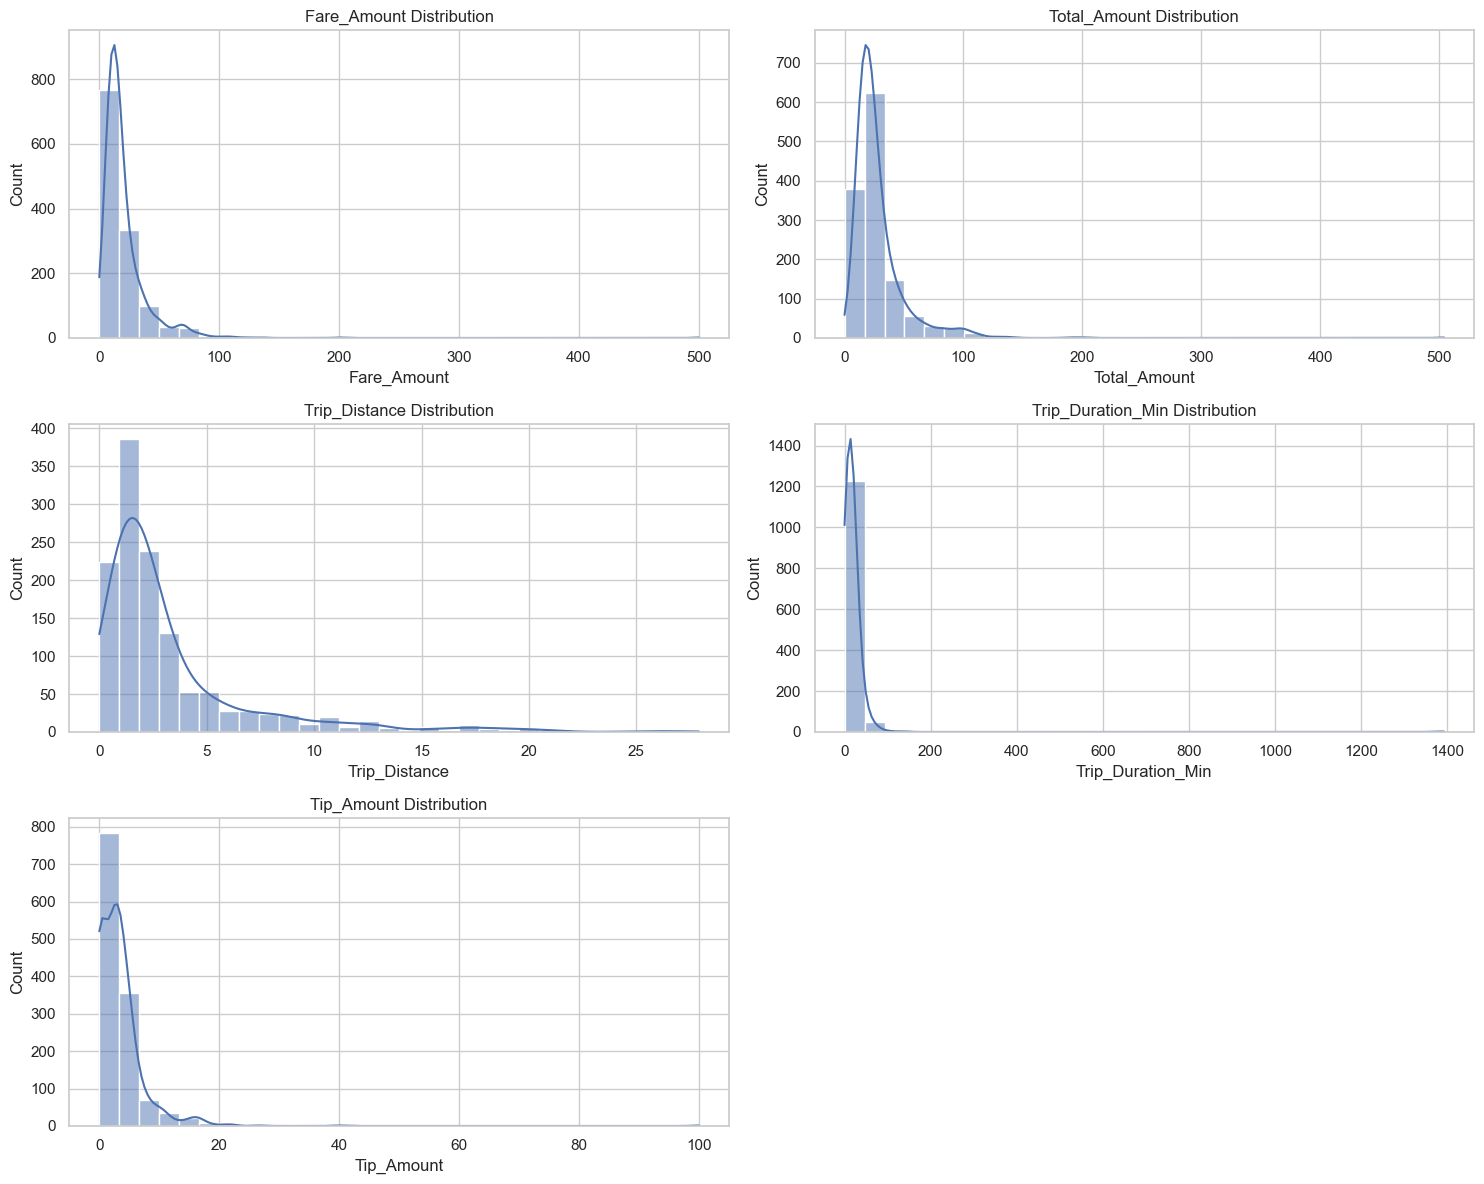

In [5]:
sns.set(style="whitegrid")

continuous_cols = [
    "fare_amount",
    "total_amount",
    "trip_distance",
    "trip_duration_min",
    "tip_amount"
]

discrete_cols = [
    "passenger_count",
    "extra",
    "mta_tax",
    "improvement_surcharge",
    "congestion_surcharge",
    "cbd_congestion_fee",
    "tolls_amount"
]

continuous_cols = [c for c in continuous_cols if c in df_quant.columns]
discrete_cols   = [c for c in discrete_cols if c in df_quant.columns]

def plot_continuous(ax, s, bins=30, kde=True, cap_q=None):
    s = s.dropna().astype(float)
    if cap_q is not None and len(s) > 0:
        s = s[s <= s.quantile(cap_q)]  
    sns.histplot(s, bins=bins, kde=kde, ax=ax)
    ax.set_ylabel("Count")

def plot_discrete_bars(ax, s, max_xticks=8, sort_by="value"):
    """
    Plot discrete-numeric variables as categorical bars 
    sort_by:
      - "value" : x-axis sorted by numeric value (0, 0.5, 2.5, ...)
      - "freq"  : x-axis sorted by frequency (most common first)
    """
    s = s.dropna()
    if s.empty:
        ax.set_visible(False)
        return

    # counts
    vc = s.value_counts()
    if sort_by == "value":
        try:
            vc = vc.sort_index()
        except TypeError:
            pass  
    elif sort_by == "freq":
        vc = vc  

    def fmt(v):
        try:
            v = float(v)
            if abs(v - round(v)) < 1e-9:
                return str(int(round(v)))
            return f"{v:.2f}".rstrip("0").rstrip(".")
        except Exception:
            return str(v)

    labels = [fmt(v) for v in vc.index]
    y = vc.values

    ax.bar(labels, y)
    ax.set_ylabel("Frequency")

    if len(labels) > max_xticks:
        step = int(np.ceil(len(labels) / max_xticks))
        for i, tick in enumerate(ax.get_xticklabels()):
            tick.set_visible(i % step == 0)

    ax.tick_params(axis="x", rotation=0)

def plot_grid(cols, plot_fn, n_cols=3, figsize_base=(15, 4), **plot_kwargs):
    n_rows = math.ceil(len(cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_base[0], figsize_base[1] * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, col in zip(axes, cols):
        s = df_quant[col]
        plot_fn(ax, s, **plot_kwargs)
        ax.set_title(f"{col.title()} Distribution")
        ax.set_xlabel(col.title())

    for ax in axes[len(cols):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

# Plot continuous: histogram + KDE
plot_grid(
    continuous_cols,
    plot_continuous,
    n_cols=2,
    bins=30,
    kde=True,
    cap_q=None
)


Based on the histograms of the continuous numeric variables from our data, it is seen that they all have right-skewed distributions, each with a large concentration of observations at small values. 

- fare_amount: most fares are relatively low
- total_amount: similar pattern to fare_amount
- trip_distance: most trips are fairly short
- trip_duration_min: similar to trip_distance, most trips are short
- tip_amount: most tips are small or zero

There are also a small number of outliers resulting from long or expensive rides.  


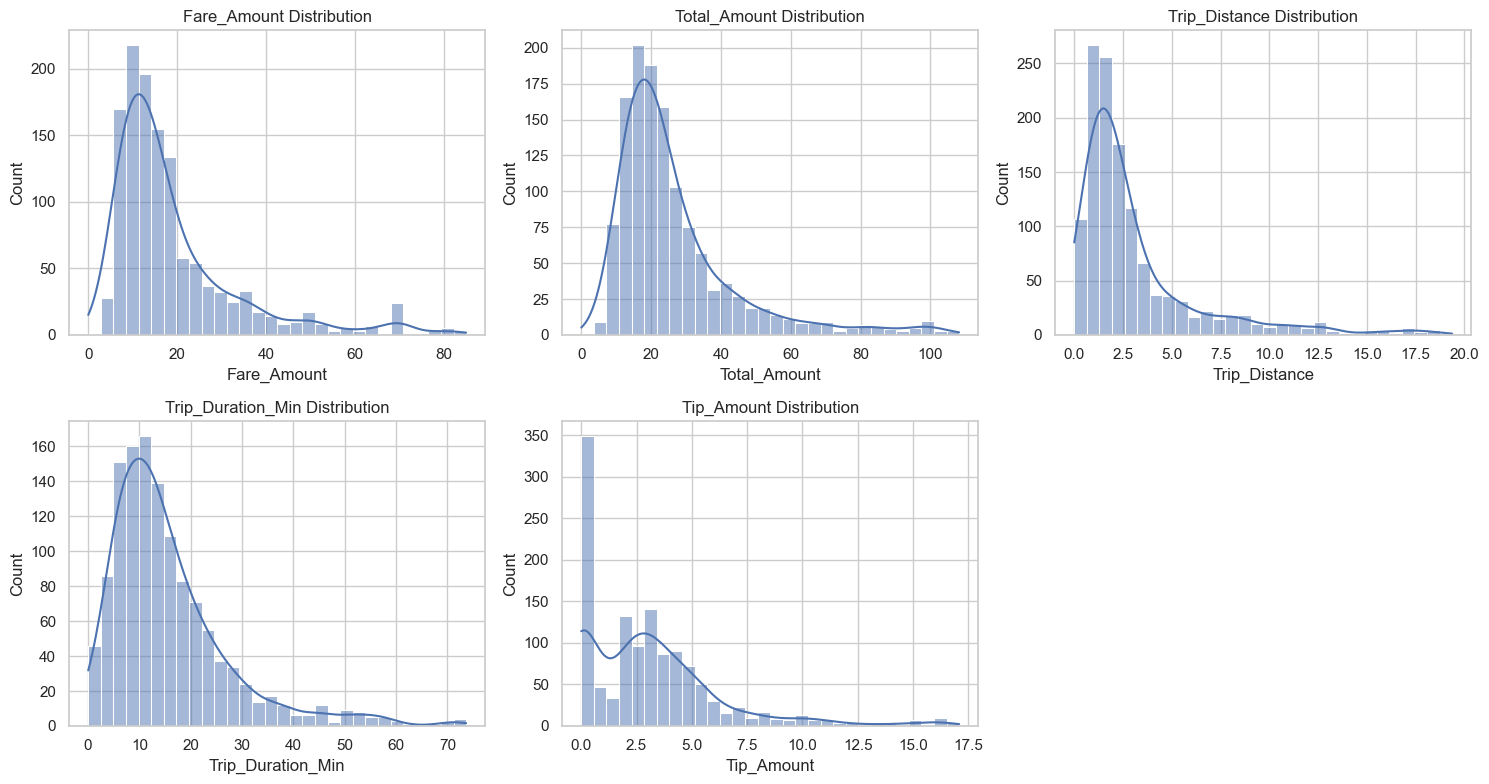

In [6]:
# Removing outliers
plot_grid(
    continuous_cols,
    plot_continuous,
    n_cols=3,
    bins=30,
    kde=True,
    cap_q=0.99
)

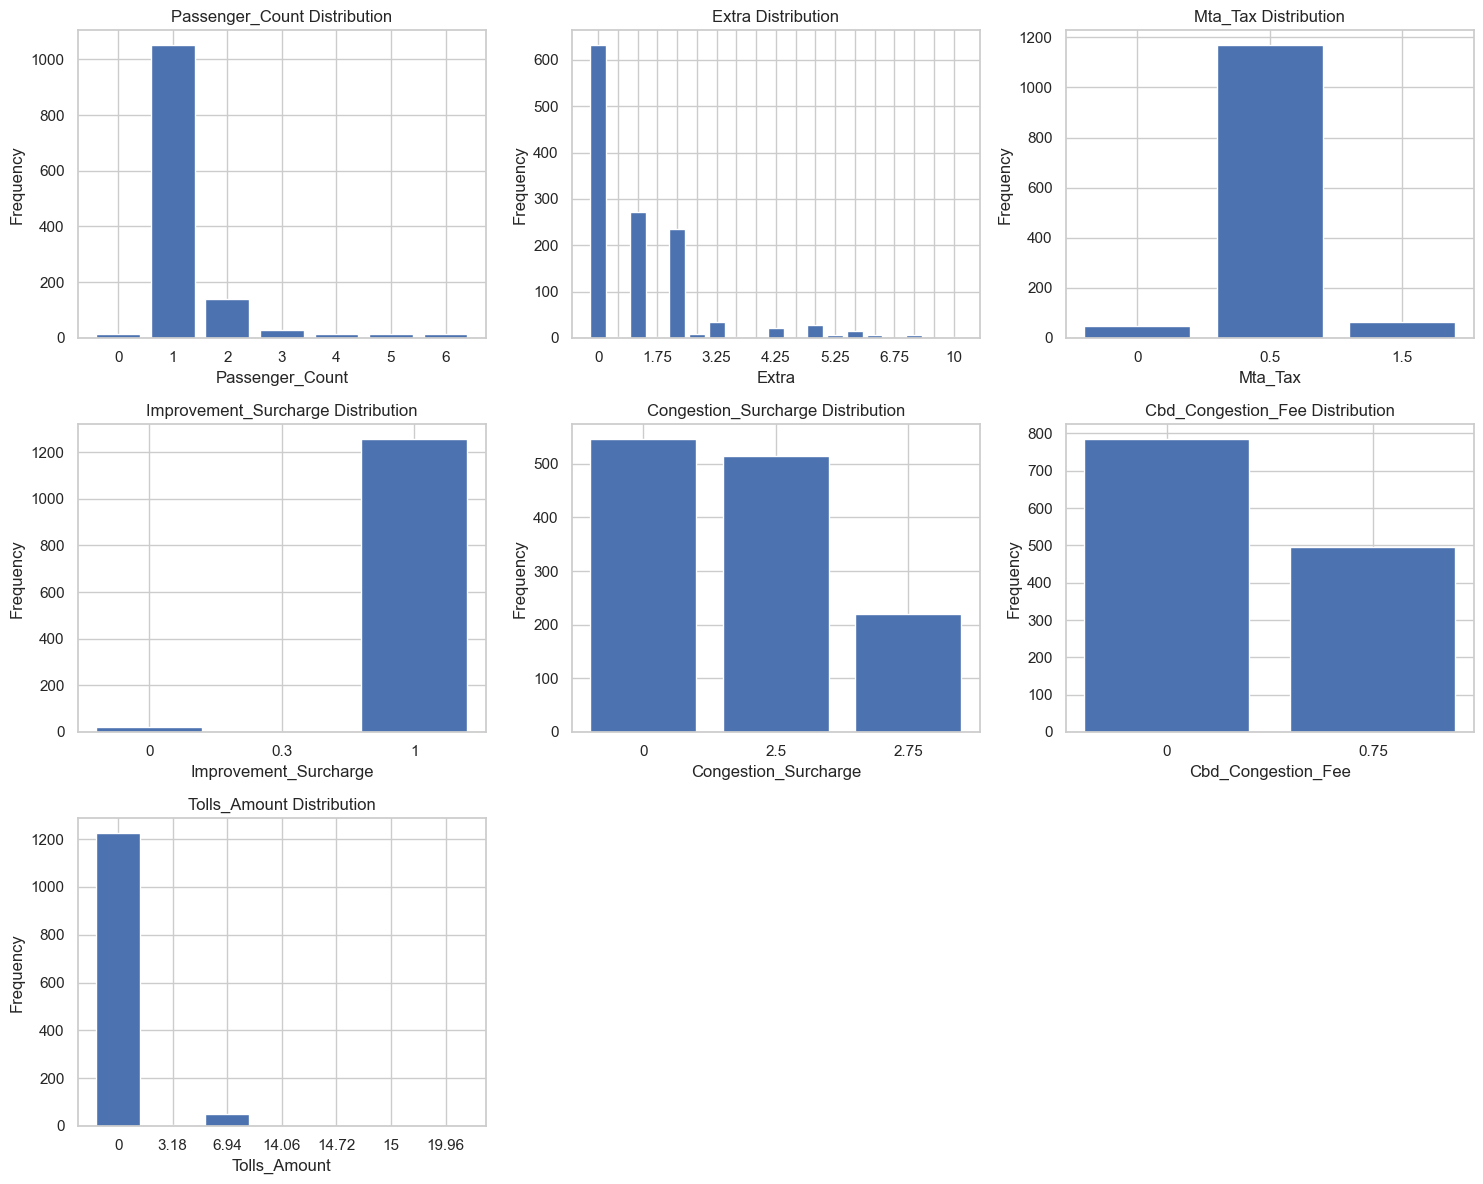

In [7]:
# Plot discrete numeric
plot_grid(
    discrete_cols,
    plot_discrete_bars,
    n_cols=3,
    max_xticks=8,
    sort_by="value"  
)

Based on the visualizations, several fare-related variables are discrete numeric encoded but represent policy-driven changes. For example, mta_tax, improvement_surcharge, congestion_surcharge, and cbd_congestion all only take on 2 or 3 values in total. Additionally, majority of the rides have, for example, an improvement surcharge of 1.0, and an MTA tax of 0.5. We believe that this reflects mandatory policy rules within New York rather than data imbalance. Therefore, these variables are not included below in the imbalance analysis for categorical variables.

In [8]:
df_cat = df.copy()

# convert datetime 
df_cat["pickup_datetime"]  = pd.to_datetime(df_cat["pickup_datetime"], errors="coerce")
df_cat["dropoff_datetime"] = pd.to_datetime(df_cat["dropoff_datetime"], errors="coerce")

# separate by hour and day of week
df_cat["pickup_hour"] = df_cat["pickup_datetime"].dt.hour
df_cat["pickup_dow"]  = df_cat["pickup_datetime"].dt.dayofweek

df_cat["dropoff_hour"] = df_cat["dropoff_datetime"].dt.hour
df_cat["dropoff_dow"]  = df_cat["dropoff_datetime"].dt.dayofweek

In [9]:
cat_plot_cols = [
    "taxi_type",
    "payment_type",
    "pulocationid",
    "dolocationid",
    "pickup_hour",
    "pickup_dow",
    "dropoff_hour",
    "dropoff_dow",
]

cat_plot_cols = [c for c in cat_plot_cols if c in df_cat.columns]

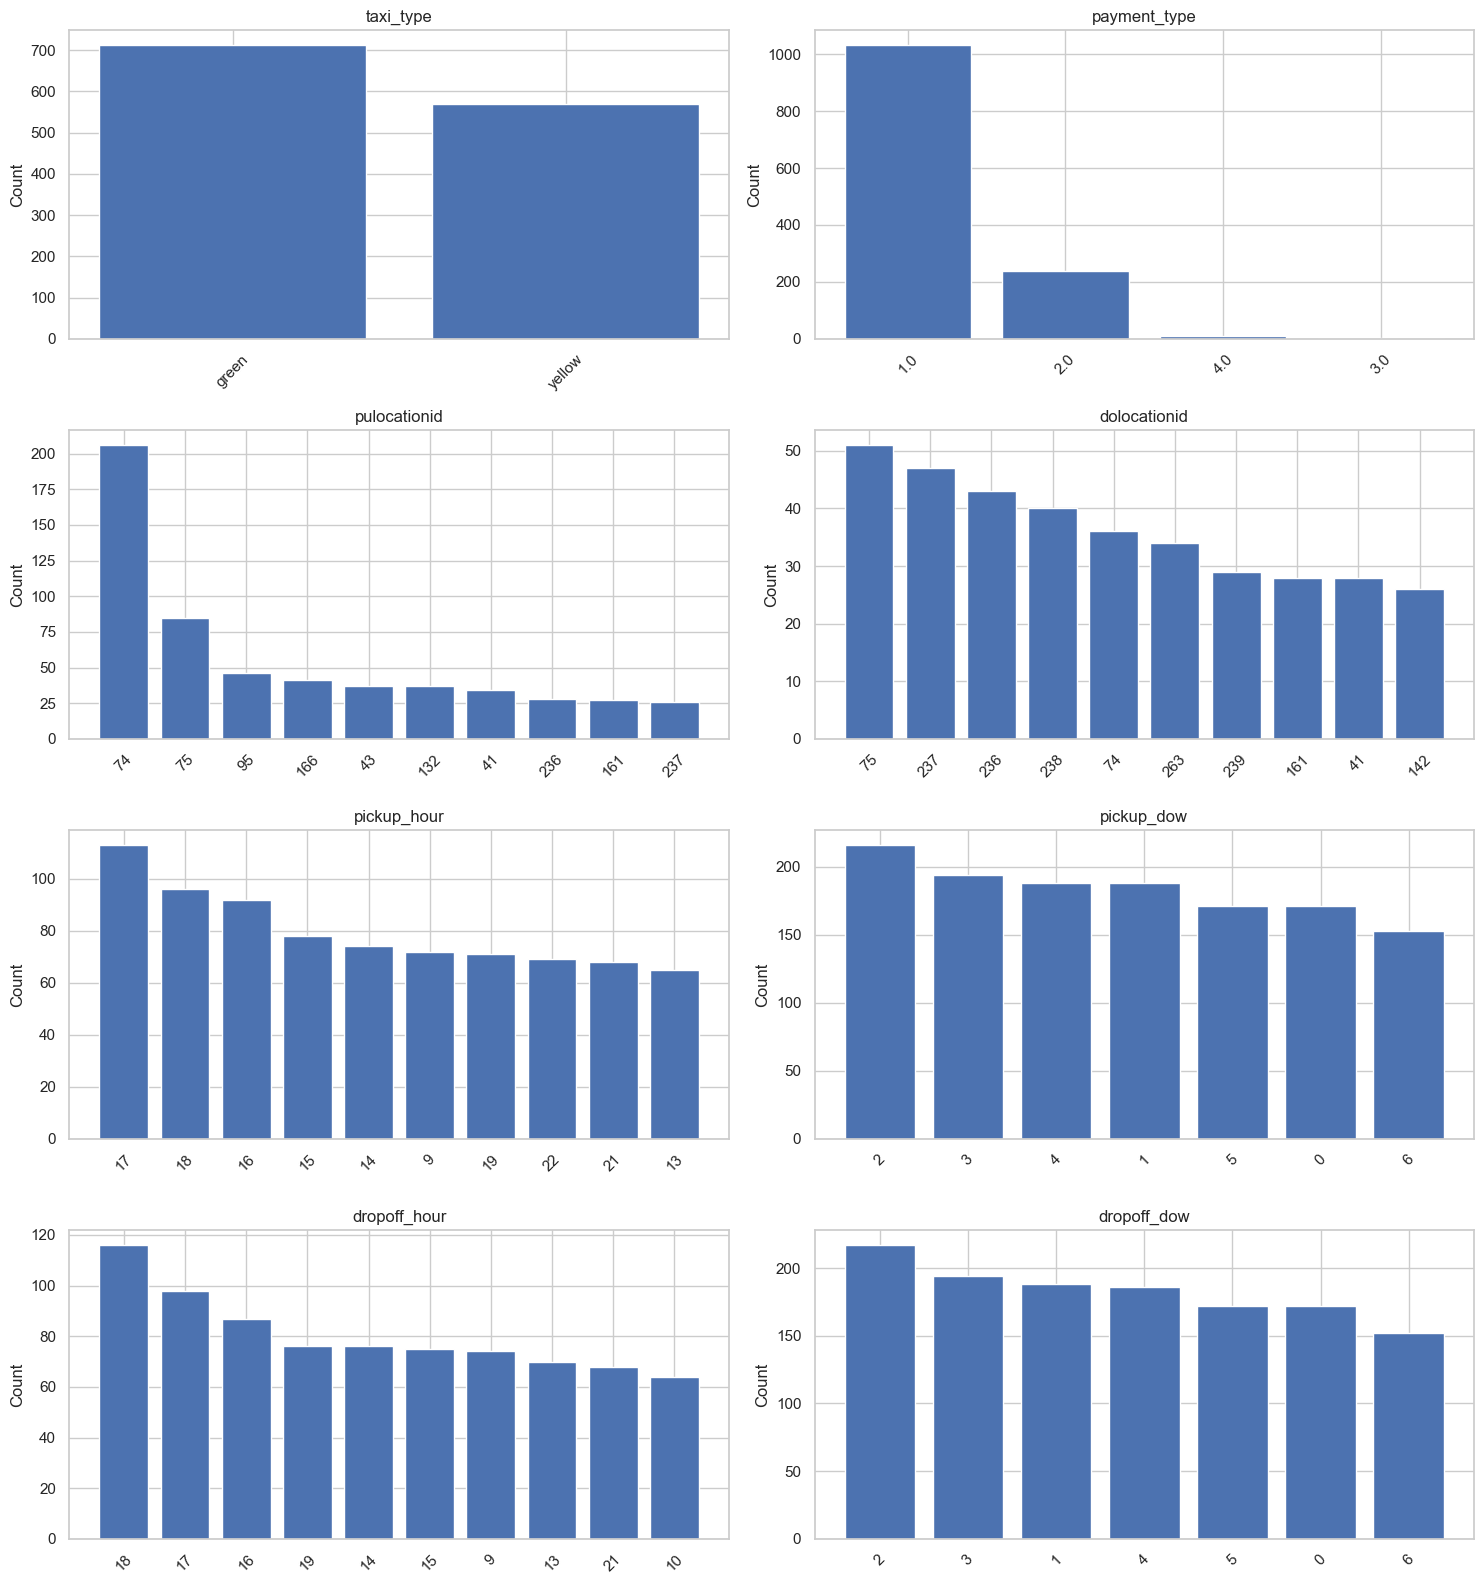

In [10]:
# plot categorical vars

sns.set(style="whitegrid")

n_cols = 2
n_rows = math.ceil(len(cat_plot_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_plot_cols):
    vc = df_cat[col].value_counts()

    if len(vc) > 10:
        vc = vc.head(10)

    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.set_xlabel("")

    ax.tick_params(axis="x", rotation=45)

for ax in axes[len(cat_plot_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


It can be seen in the bar plots above that there is a high imbalance for:
- payment_type, where most passengers pay with type 1.0 (credit card) compared to the rest (e.g. cash)
- pulocationid, where majority of drivers pick up rides in a specific taxi zone (74)

### 3) Correlation Matrix

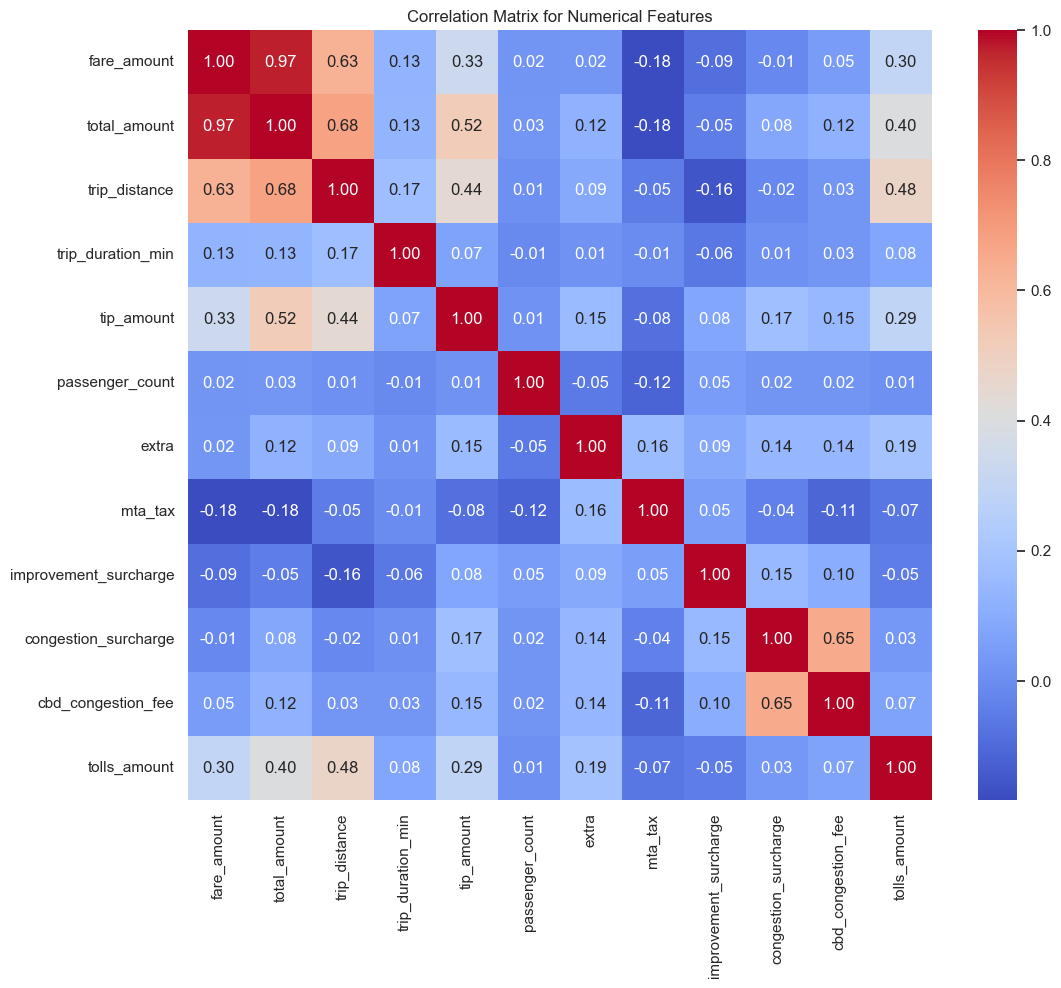

In [11]:
all_cols = continuous_cols + discrete_cols
num_cols = df[all_cols].columns

corr = df[num_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

There are strong correlations between: 
- fare_amount and total_amount (0.97)
- fare_amount and trip_distance (0.63)
- total_amount and trip_distance (0.68)
- congestion_surcharge and cbd_congestion_fee: 0.65 

Fare and total cost are strongly driven by trip distance which align with the expected pricing structure of taxi trips. Additionally, the strong correlation between congestion-related fees reflects fare policy rules rather than independent behavioral relationships. 

There are moderate correlations between: 
- tip_amount and total_amount (0.52)
- tolls_amount and trip_distance (0.48) 

Tips increase with trip cost and distance, and longer trips are more likely to incur tolls which contributes to higher total costs. This all aligns with real-world travel patterns. 

 There are weak correlations between:
- trip_duration_min and trip_distance (0.17)
- trip_duration_min and fare_amount (0.13)
- trip_duration_min and total_amount (0.13) 

Trip duration shows weak correlation with distance and cost, which suggests that traffic conditions and time-of-day play an important role. 

Multi-collinearity however would be handled during feature selection in downstream modeling. 